In [5]:
import numpy as np
import pandas as pd
import os
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import shap
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import precision_score, recall_score, f1_score
from copy import deepcopy
from math import sqrt
from sklearn.utils import resample
from itertools import product

# Standard libraries
import os
import copy
from math import sqrt

# Data handling
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Scikit-learn core utilities
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.utils import resample, compute_class_weight

# Scikit-learn metrics
from sklearn.metrics import (
    roc_curve, auc, precision_score, recall_score, f1_score, 
    accuracy_score, roc_auc_score, precision_recall_curve, 
    average_precision_score, confusion_matrix, ConfusionMatrixDisplay, 
    classification_report
)

# Scikit-learn models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# External libraries
import shap
from xgboost import XGBClassifier
import xgboost as xgb

from joblib import Parallel, delayed

In [6]:
merged_cohort = pd.read_csv("merged_file.csv")
y = merged_cohort['Outcome_Occlusion_MI']
X = merged_cohort.drop('Outcome_Occlusion_MI', axis=1)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=0.2,  # 30% for val+test (which is 15%+15%)
    stratify=y,
    random_state=99
)
'''
# Step 2: Split the temp set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,  # 50% of 30% = 15% of original data
    stratify=y_temp,  # Maintain stratification in this split too
    random_state=99
)
'''
# Verify the proportions
print(f"Training set: {len(X_train)} samples ({len(X_train)/len(X):.1%})")
print(f"Validation set: {len(X_val)} samples ({len(X_val)/len(X):.1%})")
#print(f"Test set: {len(X_test)} samples ({len(X_test)/len(X):.1%})")

Training set: 5850 samples (80.0%)
Validation set: 1463 samples (20.0%)


In [7]:
for el in X_train.columns:
    X_train[el].fillna(X_train[el].mode()[0], inplace=True)
    #X_test[el].fillna(X_train[el].mode()[0], inplace=True)
    X_val[el].fillna(X_train[el].mode()[0], inplace=True)

y_train = np.ravel(np.array(y_train.values))
#y_test = np.ravel(np.array(y_test.values))
y_val = np.ravel(np.array(y_val.values))

columns = X_train.columns

C:\Users\arthu\AppData\Local\Temp\ipykernel_110800\1319206832.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train[el].fillna(X_train[el].mode()[0], inplace=True)
C:\Users\arthu\AppData\Local\Temp\ipykernel_110800\1319206832.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

In [10]:
# 1. Train the best model on the entire training set
best_xgb = XGBClassifier(
        n_estimators=180,
        max_depth=3,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.7,
        reg_alpha=0,
        reg_lambda=0,
        tree_method="hist",
        n_jobs=-1,
        random_state=42)

# Fit the model on the entire training set
best_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=180, n_jobs=-1,
              num_parallel_tree=None, random_state=42, ...)

In [11]:
def plot_ROC_curve(fpr, tpr, roc_auc, title):
    plt.figure(figsize=[5, 5])
    plt.title(title)
    plt.plot(fpr, tpr, color='b',
                 label=r'XGB (AUC = %0.3f)' % (roc_auc),
                 lw=2, alpha=.8)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='grey', alpha=.5)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate = 1 - Specificity')
    plt.ylabel('True Positive Rate = Sensitivity')
    plt.legend(loc="lower right")
    plt.show()

In [12]:
def bootstrap_metric_ci(y_true, y_pred, metric_fn, n_bootstrap=1000, alpha=0.05):
    """
    Compute 95% confidence interval using bootstrapping for any metric.
    
    Parameters:
    - y_true: Ground truth labels (0 or 1).
    - y_pred: Predicted values (either probabilities or binary predictions).
    - metric_fn: Metric function (roc_auc_score, recall_score, f1_score).
    - n_bootstrap: Number of bootstrap resamples.
    - alpha: Significance level (default 0.05 for 95% CI).

    Returns:
    - Lower and upper bound of the confidence interval.
    """
    scores = []
    
    for _ in range(n_bootstrap):
        # Resample dataset with replacement
        indices = resample(range(len(y_true)), replace=True, n_samples=len(y_true))
        y_true_bootstrap = np.array(y_true)[indices]
        y_pred_bootstrap = np.array(y_pred)[indices]

        # Special case for AUROC: Use roc_curve and auc()
        if metric_fn == "auroc":
            fpr, tpr, _ = roc_curve(y_true_bootstrap, y_pred_bootstrap)
            score = auc(fpr, tpr)
        else:
            score = metric_fn(y_true_bootstrap, y_pred_bootstrap)

        scores.append(score)
    
    # Compute confidence interval
    lower_bound = np.percentile(scores, 100 * (alpha / 2))
    upper_bound = np.percentile(scores, 100 * (1 - alpha / 2))
    
    return lower_bound, upper_bound

In [15]:
def results(pred_probas):
    OMI_score = np.round(pred_probas[:, 1]*100, decimals=2)
    y_pred = np.where(OMI_score<3.2, 'Low risk', 'Intermediate risk')
    y_pred = np.where(OMI_score>=25, 'High risk', y_pred)
    
    results = {
        'Low risk': [np.count_nonzero(y_pred == 'Low risk')],
        'Intermediate risk': [np.count_nonzero(y_pred == 'Intermediate risk')],
        'High risk': [np.count_nonzero(y_pred == 'High risk')]
    }
    return(pd.DataFrame(data=results, index=['Count (N)']))

Validation


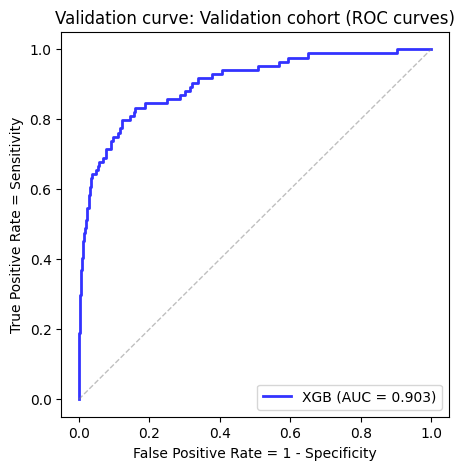

Val AUROC: 0.903 (95% CI: 0.865, 0.939)


In [16]:
print("Validation")
pred_probas_val = best_xgb.predict_proba(X_val)
risk_groups_val = results(pred_probas_val)

# Compute ROC curve and area under the curve
fpr, tpr, thresholds = roc_curve(y_val, pred_probas_val[:,1])
roc_auc = auc(fpr, tpr)
plot_ROC_curve(fpr, tpr, roc_auc, 'Validation curve: Validation cohort (ROC curves)')
#plot_Shapley(clf, X_val, columns, 'Derivation cohort', 25)
# Compute AUROC CI
auroc_ci_lower_val, auroc_ci_upper_val = bootstrap_metric_ci(y_val, pred_probas_val[:,1], "auroc")

print(f"Val AUROC: {roc_auc:.3f} (95% CI: {auroc_ci_lower_val:.3f}, {auroc_ci_upper_val:.3f})")

In [25]:
######new
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix
from scipy import stats

def calculate_wilson_ci(p, n, z=1.96):
    """
    Calculate Wilson score interval for a proportion
    
    Parameters:
    -----------
    p : float
        Proportion (e.g., sensitivity, specificity)
    n : int
        Sample size
    z : float
        z-score for desired confidence level (default 1.96 for 95% CI)
    
    Returns:
    --------
    tuple
        (lower_bound, upper_bound)
    """
    # Handle edge cases
    if n == 0:
        return (0.0, 1.0)
    
    # Wilson score interval calculation
    denominator = 1 + z**2/n
    center = (p + z**2/(2*n))/denominator
    half_width = z * np.sqrt(p*(1-p)/n + z**2/(4*n**2))/denominator
    
    lower_bound = max(0.0, center - half_width)
    upper_bound = min(1.0, center + half_width)
    
    return (lower_bound, upper_bound)

def evaluate_risk_stratification(y_test, pred_probas_test, low_threshold, high_threshold):
    """
    Evaluate the performance of risk stratification using the determined thresholds
    
    Parameters:
    -----------
    y_test : array-like
        Ground truth labels for validation set
    pred_probas_test : array-like
        Predicted probabilities from the model
    low_threshold : float
        Threshold for low risk classification
    high_threshold : float
        Threshold for high risk classification
        
    Returns:
    --------
    dict
        Dictionary containing performance metrics with 95% CIs
    """
    # Scale probabilities to 0-100 range
    OMI_score = np.round(pred_probas_test[:, 1]*100, decimals=2)
    
    # Create risk categories
    risk_categories = np.ones(len(y_test))  # Default is intermediate
    risk_categories[OMI_score < low_threshold] = 0  # Low risk
    risk_categories[OMI_score >= high_threshold] = 2  # High risk
    
    # Calculate counts
    low_count = np.sum(risk_categories == 0)
    intermediate_count = np.sum(risk_categories == 1)
    high_count = np.sum(risk_categories == 2)
    
    # Calculate OMI prevalence in each category
    low_positives = np.sum((risk_categories == 0) & (y_test == 1))
    low_prevalence = low_positives / low_count * 100 if low_count > 0 else 0
    
    intermediate_positives = np.sum((risk_categories == 1) & (y_test == 1))
    intermediate_prevalence = intermediate_positives / intermediate_count * 100 if intermediate_count > 0 else 0
    
    high_positives = np.sum((risk_categories == 2) & (y_test == 1))
    high_prevalence = high_positives / high_count * 100 if high_count > 0 else 0
    
    # Rule-out strategy
    y_rule_out = (risk_categories > 0).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_rule_out).ravel()
    
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0
    miss_rate = fn / (tn + fn) if (tn + fn) > 0 else 0
    
    # Calculate 95% CIs for rule-out metrics
    sensitivity_ci = calculate_wilson_ci(sensitivity, tp + fn)
    npv_ci = calculate_wilson_ci(npv, tn + fn)
    miss_rate_ci = calculate_wilson_ci(miss_rate, tn + fn)
    
    # Rule-in strategy
    y_rule_in = (risk_categories == 2).astype(int)
    tn_in, fp_in, fn_in, tp_in = confusion_matrix(y_test, y_rule_in).ravel()
    
    specificity = tn_in / (tn_in + fp_in) if (tn_in + fp_in) > 0 else 0
    ppv = tp_in / (tp_in + fp_in) if (tp_in + fp_in) > 0 else 0
    false_discovery_rate = fp_in / (tp_in + fp_in) if (tp_in + fp_in) > 0 else 0
    
    # Calculate 95% CIs for rule-in metrics
    specificity_ci = calculate_wilson_ci(specificity, tn_in + fp_in)
    ppv_ci = calculate_wilson_ci(ppv, tp_in + fp_in)
    false_discovery_rate_ci = calculate_wilson_ci(false_discovery_rate, tp_in + fp_in)
    
    # Also calculate CIs for prevalence estimates
    low_prevalence_ci = calculate_wilson_ci(low_prevalence/100, low_count) if low_count > 0 else (0, 0)
    intermediate_prevalence_ci = calculate_wilson_ci(intermediate_prevalence/100, intermediate_count) if intermediate_count > 0 else (0, 0)
    high_prevalence_ci = calculate_wilson_ci(high_prevalence/100, high_count) if high_count > 0 else (0, 0)
    
    # Scale prevalence CIs back to percentage
    low_prevalence_ci = (low_prevalence_ci[0] * 100, low_prevalence_ci[1] * 100)
    intermediate_prevalence_ci = (intermediate_prevalence_ci[0] * 100, intermediate_prevalence_ci[1] * 100)
    high_prevalence_ci = (high_prevalence_ci[0] * 100, high_prevalence_ci[1] * 100)
    
    # Create visualization of risk stratification
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Left: frequency histogram by category
    category_names = ['Low risk\n+', 'Intermediate risk\n++', 'High risk\n+++']
    counts = [low_count, intermediate_count, high_count]
    percentages = [100 * count / len(y_test) for count in counts]
    
    ax1.bar(category_names, counts)
    ax1.set_title('Patient Distribution by Risk Category')
    ax1.set_ylabel('Number of Patients')
    
    # Add count and percentage labels
    for i, (count, percentage) in enumerate(zip(counts, percentages)):
        ax1.annotate(f'{count}\n({percentage:.1f}%)', 
                     xy=(i, count), 
                     ha='center', va='bottom')
    
    # Right: OMI prevalence by category
    prevalences = [low_prevalence, intermediate_prevalence, high_prevalence]
    
    ax2.bar(category_names, prevalences, color='orangered')
    ax2.set_title('OMI Prevalence by Risk Category')
    ax2.set_ylabel('OMI Prevalence (%)')
    
    # Add prevalence labels with CIs
    ci_texts = [
        f'{low_prevalence:.1f}%\n({low_prevalence_ci[0]:.1f}-{low_prevalence_ci[1]:.1f}%)',
        f'{intermediate_prevalence:.1f}%\n({intermediate_prevalence_ci[0]:.1f}-{intermediate_prevalence_ci[1]:.1f}%)',
        f'{high_prevalence:.1f}%\n({high_prevalence_ci[0]:.1f}-{high_prevalence_ci[1]:.1f}%)'
    ]
    
    for i, (prev, ci_text) in enumerate(zip(prevalences, ci_texts)):
        ax2.annotate(ci_text, 
                     xy=(i, prev), 
                     ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary with confidence intervals
    print(f"\nRisk Stratification with thresholds {low_threshold:.1f} and {high_threshold:.1f}:")
    print(f"Low risk: {low_count} patients ({100*low_count/len(y_test):.1f}%)")
    print(f"Intermediate risk: {intermediate_count} patients ({100*intermediate_count/len(y_test):.1f}%)")
    print(f"High risk: {high_count} patients ({100*high_count/len(y_test):.1f}%)")
    
    print("\nOMI Prevalence with 95% CI:")
    print(f"Low risk: {low_prevalence:.1f}% ({low_prevalence_ci[0]:.1f}-{low_prevalence_ci[1]:.1f}%)")
    print(f"Intermediate risk: {intermediate_prevalence:.1f}% ({intermediate_prevalence_ci[0]:.1f}-{intermediate_prevalence_ci[1]:.1f}%)")
    print(f"High risk: {high_prevalence:.1f}% ({high_prevalence_ci[0]:.1f}-{high_prevalence_ci[1]:.1f}%)")
    
    print("\nRule-out Strategy (Low risk classified as negative) with 95% CI:")
    print(f"Sensitivity: {sensitivity:.3f} ({sensitivity_ci[0]:.3f}-{sensitivity_ci[1]:.3f})")
    print(f"NPV: {npv:.3f} ({npv_ci[0]:.3f}-{npv_ci[1]:.3f})")
    print(f"Miss rate: {miss_rate:.3f} ({miss_rate_ci[0]:.3f}-{miss_rate_ci[1]:.3f})")
    
    print("\nRule-in Strategy (High risk classified as positive) with 95% CI:")
    print(f"Specificity: {specificity:.3f} ({specificity_ci[0]:.3f}-{specificity_ci[1]:.3f})")
    print(f"PPV: {ppv:.3f} ({ppv_ci[0]:.3f}-{ppv_ci[1]:.3f})")
    print(f"False discovery rate: {false_discovery_rate:.3f} ({false_discovery_rate_ci[0]:.3f}-{false_discovery_rate_ci[1]:.3f})")
    
    return {
        'distribution': {
            'low_risk': {
                'count': int(low_count),
                'percent': 100 * low_count / len(y_test),
                'prevalence': low_prevalence,
                'prevalence_ci': low_prevalence_ci
            },
            'intermediate_risk': {
                'count': int(intermediate_count),
                'percent': 100 * intermediate_count / len(y_test),
                'prevalence': intermediate_prevalence,
                'prevalence_ci': intermediate_prevalence_ci
            },
            'high_risk': {
                'count': int(high_count),
                'percent': 100 * high_count / len(y_test),
                'prevalence': high_prevalence,
                'prevalence_ci': high_prevalence_ci
            }
        },
        'rule_out': {
            'sensitivity': sensitivity,
            'sensitivity_ci': sensitivity_ci,
            'npv': npv,
            'npv_ci': npv_ci,
            'miss_rate': miss_rate,
            'miss_rate_ci': miss_rate_ci
        },
        'rule_in': {
            'specificity': specificity,
            'specificity_ci': specificity_ci,
            'ppv': ppv,
            'ppv_ci': ppv_ci,
            'false_discovery_rate': false_discovery_rate,
            'false_discovery_rate_ci': false_discovery_rate_ci
        },
        'confusion_matrices': {
            'rule_out': {
                'tn': tn, 'fp': fp, 'fn': fn, 'tp': tp
            },
            'rule_in': {
                'tn': tn_in, 'fp': fp_in, 'fn': fn_in, 'tp': tp_in
            }
        }
    }

def plot_final_distribution(y_test, pred_probas_test, low_threshold=5, high_threshold=20, figsize=(10, 6)):
    """
    Plot the final distribution figure with risk category labels moved further below the x-axis
    
    Parameters:
    -----------
    y_test : array-like
        Ground truth labels for validation set
    pred_probas_test : array-like
        Predicted probabilities from the model
    low_threshold : float
        Threshold for low risk classification
    high_threshold : float
        Threshold for high risk classification
    figsize : tuple
        Figure size
    """
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    import matplotlib.transforms as mtransforms
    
    # Scale probabilities to 0-100 range
    OMI_score = np.round(pred_probas_test[:, 1]*100, decimals=2)
    
    # Create risk categories for counting
    risk_categories = np.ones(len(y_test))  # Default is intermediate
    risk_categories[OMI_score < low_threshold] = 0  # Low risk
    risk_categories[OMI_score >= high_threshold] = 2  # High risk
    
    # Calculate counts and percentages
    low_count = np.sum(risk_categories == 0)
    intermediate_count = np.sum(risk_categories == 1)
    high_count = np.sum(risk_categories == 2)
    
    # Calculate OMI prevalence in each category
    low_positives = np.sum((risk_categories == 0) & (y_test == 1))
    low_prevalence = low_positives / low_count * 100 if low_count > 0 else 0
    
    intermediate_positives = np.sum((risk_categories == 1) & (y_test == 1))
    intermediate_prevalence = intermediate_positives / intermediate_count * 100 if intermediate_count > 0 else 0
    
    high_positives = np.sum((risk_categories == 2) & (y_test == 1))
    high_prevalence = high_positives / high_count * 100 if high_count > 0 else 0
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize, gridspec_kw={'width_ratios': [1.5, 1]})
    
    # Separate OMI positive and negative cases
    pos_probs = OMI_score[y_test == 1]
    neg_probs = OMI_score[y_test == 0]
    
    # Left plot: Density distribution
    sns.kdeplot(neg_probs, ax=ax1, label="Normal", color='blue', fill=True, alpha=0.5)
    sns.kdeplot(pos_probs, ax=ax1, label="OMI", color='red', fill=True, alpha=0.5)
    
    # Add threshold markers
    ax1.axvline(x=low_threshold, color='black', linestyle='--', alpha=0.7)
    ax1.axvline(x=high_threshold, color='black', linestyle='--', alpha=0.7)
    
    # Set labels and title for the main plot
    ax1.set_xlabel("Probability")
    ax1.set_ylabel("Density")
    ax1.set_xlim(0, 100)
    ax1.legend()
    
    # Instead of using a secondary axis, we'll manually place the text labels
    # with a controlled offset below the x-axis
    
    # First, ensure we have extra space at the bottom of the plot
    plt.subplots_adjust(bottom=0.2)  # Increased from 0.15 to 0.2
    
    # Define positions for the labels
    label_positions = [low_threshold/2, (low_threshold+high_threshold)/2, high_threshold*1.5]
    labels = ['+', '++', '+++']
    
    # Create a transformation to convert from data coordinates to figure coordinates
    trans = mtransforms.blended_transform_factory(ax1.transData, fig.transFigure)
    
    # Add labels with significant offset below the x-axis
    # The y-coordinate is in figure coordinates where 0 is bottom and 1 is top
    label_y_pos = 0.08  # This positions the labels much lower - adjust as needed
    
    for pos, label in zip(label_positions, labels):
        ax1.text(pos, label_y_pos, label, ha='center', fontsize=12, 
                 transform=trans)
    
    # Right plot: Stacked bar chart for risk categories
    categories = ['Low risk\n+', 'Intermediate risk\n++', 'High risk\n+++']
    counts = [low_count, intermediate_count, high_count]
    
    # Calculate heights for stacked bars
    prevalences = [low_prevalence/100, intermediate_prevalence/100, high_prevalence/100]
    non_prevalences = [1-p for p in prevalences]
    
    # Create stacked bar chart
    ax2.bar(categories, non_prevalences, color='white', edgecolor='black')
    ax2.bar(categories, prevalences, bottom=non_prevalences, color='red', edgecolor='black')
    
    # Add text for percentages
    for i, (count, prev) in enumerate(zip(counts, [low_prevalence, intermediate_prevalence, high_prevalence])):
        ax2.text(i, 1.05, f"{prev:.1f}%", ha='center')
    
    # Add count text with better spacing
    for i, count in enumerate(counts):
        ax2.text(i, -0.10, f"n = {count}", ha='center')
    
    # Set labels and limits for right plot
    ax2.set_ylim(-0.15, 1.1)
    ax2.set_ylabel("% OMI")
    ax2.set_title("Thesis Model")
    
    # Adjust layout
    plt.tight_layout()
    
    return fig

# Alternative approach using a more direct method if the above doesn't position the labels low enough
def plot_final_distribution_alt(y_test, pred_probas_test, low_threshold=5, high_threshold=20, figsize=(10, 6)):
    """
    Plot the final distribution figure with risk category labels placed very low below the x-axis
    
    Parameters:
    -----------
    y_test : array-like
        Ground truth labels for validation set
    pred_probas_test : array-like
        Predicted probabilities from the model
    low_threshold : float
        Threshold for low risk classification
    high_threshold : float
        Threshold for high risk classification
    figsize : tuple
        Figure size
    """
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # Scale probabilities to 0-100 range
    OMI_score = np.round(pred_probas_test[:, 1]*100, decimals=2)
    
    # Create risk categories for counting
    risk_categories = np.ones(len(y_test))  # Default is intermediate
    risk_categories[OMI_score < low_threshold] = 0  # Low risk
    risk_categories[OMI_score >= high_threshold] = 2  # High risk
    
    # Calculate counts and percentages
    low_count = np.sum(risk_categories == 0)
    intermediate_count = np.sum(risk_categories == 1)
    high_count = np.sum(risk_categories == 2)
    
    # Calculate OMI prevalence in each category
    low_positives = np.sum((risk_categories == 0) & (y_test == 1))
    low_prevalence = low_positives / low_count * 100 if low_count > 0 else 0
    
    intermediate_positives = np.sum((risk_categories == 1) & (y_test == 1))
    intermediate_prevalence = intermediate_positives / intermediate_count * 100 if intermediate_count > 0 else 0
    
    high_positives = np.sum((risk_categories == 2) & (y_test == 1))
    high_prevalence = high_positives / high_count * 100 if high_count > 0 else 0
    
    # Create figure with two subplots, but leave extra space at the bottom
    fig = plt.figure(figsize=figsize)
    
    # Create gridspec with extra space at bottom for labels
    gs = fig.add_gridspec(2, 2, height_ratios=[1, 0.1], width_ratios=[1.5, 1])
    
    # Create main axes
    ax1 = fig.add_subplot(gs[0, 0])  # Left plot
    ax2 = fig.add_subplot(gs[0, 1])  # Right plot
    
    # Create an extra axis just for the risk labels below the density plot
    ax_labels = fig.add_subplot(gs[1, 0])
    ax_labels.axis('off')  # Hide everything except the text we'll add
    
    # Separate OMI positive and negative cases
    pos_probs = OMI_score[y_test == 1]
    neg_probs = OMI_score[y_test == 0]
    
    # Left plot: Density distribution
    sns.kdeplot(neg_probs, ax=ax1, label="Normal", color='blue', fill=True, alpha=0.5)
    sns.kdeplot(pos_probs, ax=ax1, label="OMI", color='red', fill=True, alpha=0.5)
    
    # Add threshold markers
    ax1.axvline(x=low_threshold, color='black', linestyle='--', alpha=0.7)
    ax1.axvline(x=high_threshold, color='black', linestyle='--', alpha=0.7)
    
    # Set labels and title for the main plot
    ax1.set_xlabel("Probability")
    ax1.set_ylabel("Density")
    ax1.set_xlim(0, 100)
    ax1.legend()
    
    # Add risk category labels to the bottom axis
    label_positions = [low_threshold/2, (low_threshold+high_threshold)/2, high_threshold*1.5]
    labels = ['+', '++', '+++']
    
    for pos, label in zip(label_positions, labels):
        # Position labels in the center of the label axis, aligned with the correct x positions
        ax_labels.text(pos, 0.5, label, ha='center', va='center', fontsize=12)
    
    # Set x-limits to match the main plot
    ax_labels.set_xlim(0, 100)
    
    # Right plot: Stacked bar chart for risk categories
    categories = ['Low risk\n+', 'Intermediate risk\n++', 'High risk\n+++']
    counts = [low_count, intermediate_count, high_count]
    
    # Calculate heights for stacked bars
    prevalences = [low_prevalence/100, intermediate_prevalence/100, high_prevalence/100]
    non_prevalences = [1-p for p in prevalences]
    
    # Create stacked bar chart
    ax2.bar(categories, non_prevalences, color='white', edgecolor='black')
    ax2.bar(categories, prevalences, bottom=non_prevalences, color='red', edgecolor='black')
    
    # Add text for percentages
    for i, (count, prev) in enumerate(zip(counts, [low_prevalence, intermediate_prevalence, high_prevalence])):
        ax2.text(i, 1.05, f"{prev:.1f}%", ha='center')
    
    # Add count text with better spacing
    for i, count in enumerate(counts):
        ax2.text(i, -0.10, f"n = {count}", ha='center')
    
    # Set labels and limits for right plot
    ax2.set_ylim(-0.15, 1.1)
    ax2.set_ylabel("% OMI")
    ax2.set_title("Thesis Model")
    
    # Adjust layout
    plt.tight_layout()
    
    return fig

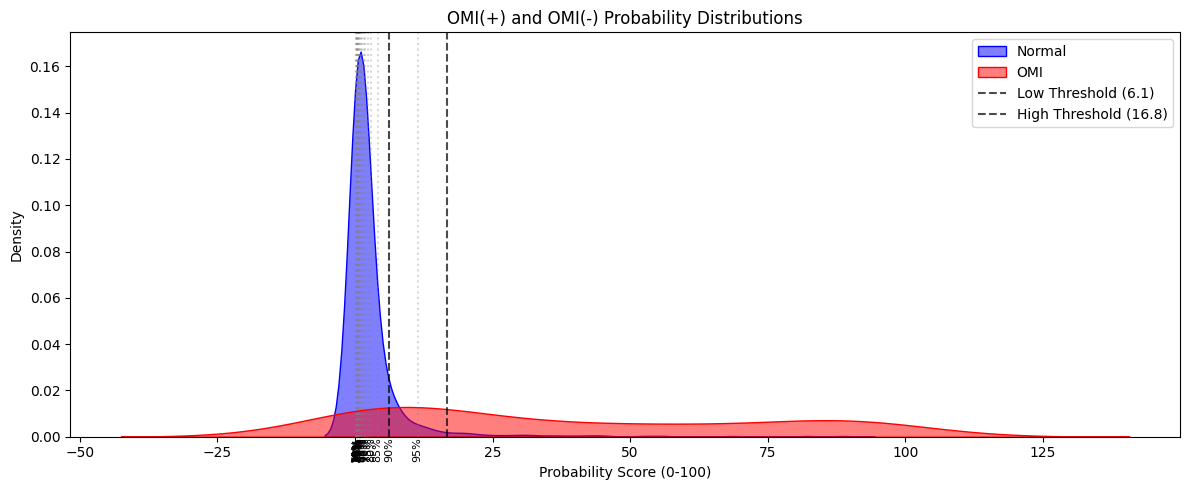

Evaluating multiple threshold combinations...

Top threshold combinations by overall utility:
    low_threshold  high_threshold  sensitivity       npv  specificity  \
9        3.000000       25.000000     0.845238  0.988403     0.978970   
8        3.000000       23.888889     0.845238  0.988403     0.978245   
49       3.888889       25.000000     0.833333  0.988075     0.978970   
39       3.666667       25.000000     0.833333  0.988003     0.978970   
29       3.444444       25.000000     0.833333  0.987858     0.978970   

         ppv  utility_score  
9   0.597222       0.852458  
8   0.594595       0.851620  
49  0.597222       0.849400  
39  0.597222       0.849382  
29  0.597222       0.849346  

Threshold combinations meeting clinical criteria (based on paper):
    low_threshold  high_threshold  low_percent  intermediate_percent  \
9        3.000000       25.000000    76.623377             18.455229   
8        3.000000       23.888889    76.623377             18.318524   
49 

C:\Users\arthu\AppData\Local\Temp\ipykernel_110800\1060898048.py:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clinical_criteria['paper_score'] = (


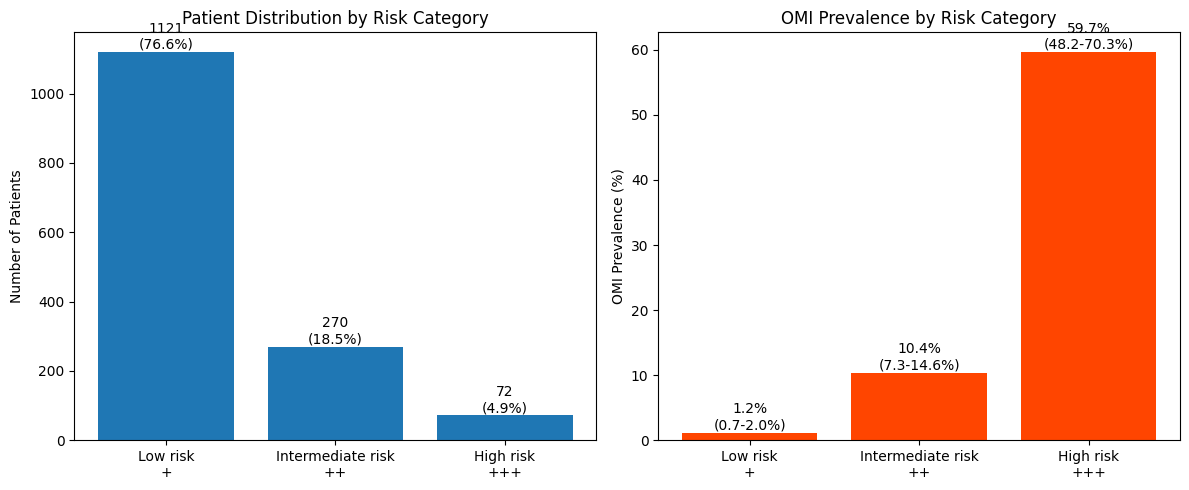


Risk Stratification with thresholds 3.0 and 25.0:
Low risk: 1121 patients (76.6%)
Intermediate risk: 270 patients (18.5%)
High risk: 72 patients (4.9%)

OMI Prevalence with 95% CI:
Low risk: 1.2% (0.7-2.0%)
Intermediate risk: 10.4% (7.3-14.6%)
High risk: 59.7% (48.2-70.3%)

Rule-out Strategy (Low risk classified as negative) with 95% CI:
Sensitivity: 0.845 (0.753-0.907)
NPV: 0.988 (0.980-0.993)
Miss rate: 0.012 (0.007-0.020)

Rule-in Strategy (High risk classified as positive) with 95% CI:
Specificity: 0.979 (0.970-0.985)
PPV: 0.597 (0.482-0.703)
False discovery rate: 0.403 (0.297-0.518)


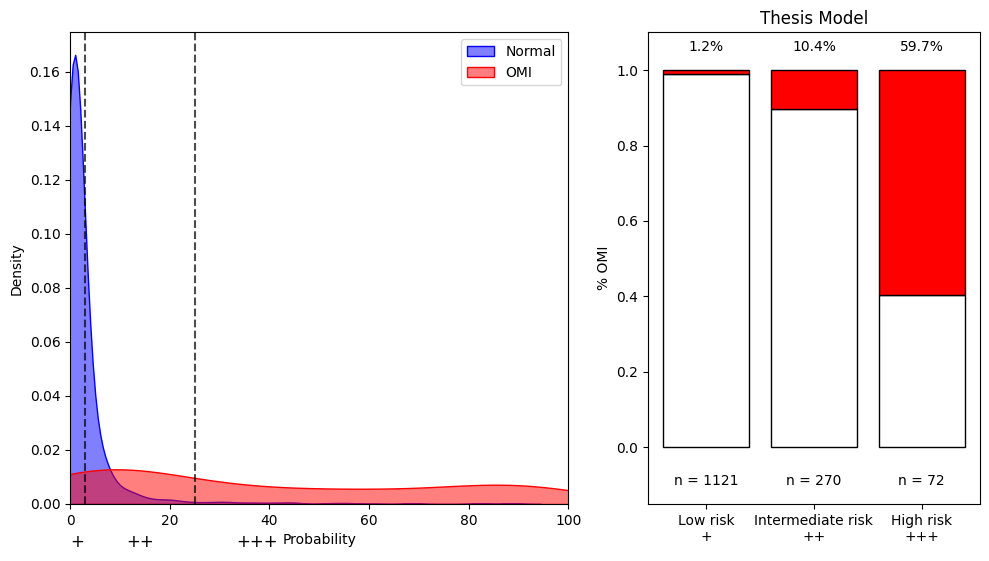

In [26]:
# Import the code above into your notebook

# Option 1: Determine optimal thresholds automatically
low_threshold, high_threshold = determine_optimal_thresholds(y_val, pred_probas_val)

# Option 2: Use the thresholds from the paper (5 and 20)
# low_threshold, high_threshold = 5, 20

# Evaluate the risk stratification with the determined thresholds
metrics = evaluate_risk_stratification(y_val, pred_probas_val, low_threshold, high_threshold)

# Create the final distribution plot similar to Figure 2b in the paper
fig = plot_final_distribution(y_val, pred_probas_val, low_threshold, high_threshold)

In [20]:
def results(pred_probas):
    OMI_score = np.round(pred_probas[:, 1]*100, decimals=2)
    y_pred = np.where(OMI_score<3, 'Low risk', 'Intermediate risk')
    y_pred = np.where(OMI_score>=25, 'High risk', y_pred)
    
    results = {
        'Low risk': [np.count_nonzero(y_pred == 'Low risk')],
        'Intermediate risk': [np.count_nonzero(y_pred == 'Intermediate risk')],
        'High risk': [np.count_nonzero(y_pred == 'High risk')]
    }
    return(pd.DataFrame(data=results, index=['Count (N)']))